In [28]:
from pathlib import Path
from math import sqrt

import numpy as np

from numba import njit

from matplotlib import pyplot as plt

### Load reference data

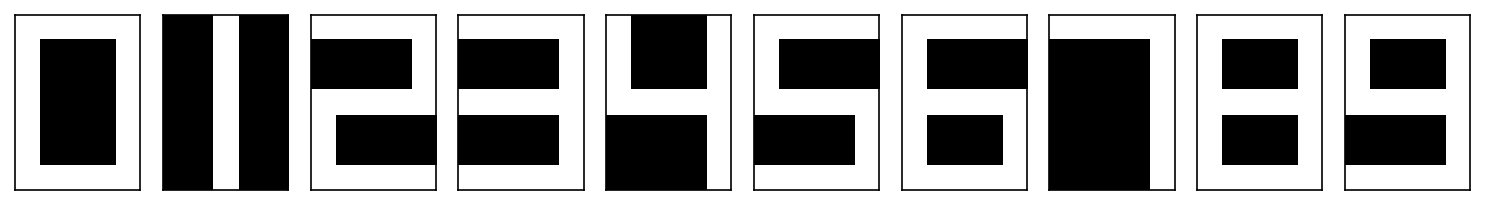

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(150)
fig.set_figwidth(10)
fig.set_figheight(5)

img_shape = (7, 5)
img_size = 35

data_path = Path(r'D:/Development/Data/datasets/txt/numbers_7x5.txt')
data_mtrx = np.loadtxt(data_path)

for n, ax in zip(data_mtrx, axes.ravel()):
    ax.imshow(n.reshape(img_shape), cmap='binary_r')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

### Generate dataset

In [30]:
def one_hot_encoding(n: int, idx: int) -> np.ndarray:
    q = np.zeros(n)
    q[idx] = 1.0
    return q

In [31]:
features = []
labels = []

for i, reference_sample in enumerate(data_mtrx):
    features.append(reference_sample)
    labels.append(one_hot_encoding(10, i))

    for j in range(9):
        noised_sample = reference_sample + np.random.uniform(0.0, 0.25, img_size)
        
        features.append(noised_sample)
        labels.append(one_hot_encoding(10, i))

features = np.array(features)
labels = np.array(labels)

### Split dataset to test and train

In [32]:
test_frac = 0.2

p = np.arange(10)

test_size = int(p.size * test_frac)
train_size = int(p.size * (1 - test_frac))

idx_test = np.ravel([(p[0:test_size] + i * 10) for i in range(10)])
idx_train = np.ravel([(p[test_size:p.size] + i * 10) for i in range(10)])

x_test = np.array(features[idx_test])
y_test = np.array(labels[idx_test])

x_train = np.array(features[idx_train])
y_train = np.array(labels[idx_train])

### Define functions

In [33]:
@njit(fastmath=True)
def norm(x: np.ndarray) -> float:
    return sqrt(np.sum(np.square(x)))


@njit(fastmath=True)
def cosim(a: np.ndarray, b: np.ndarray) -> float:
    return (a @ b) / (norm(a) * norm(b))


@njit(fastmath=True)
def mcosim(m: np.ndarray, x: np.ndarray) -> float:
    y = np.zeros(m.shape[0])
    x_norm = norm(x)
    
    for i in range(m.shape[0]):
        y[i] = (m[i] @ x) / (norm(m[i]) * x_norm)
        
    return y


@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))


@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y / np.sum(y)

### Define model

In [34]:
@njit(fastmath=True)
def grads_v(x_batch: np.ndarray, y_batch: np.ndarray, V: np.ndarray) -> tuple[np.ndarray]:
    dV = np.zeros(V.shape)

    for i in range(x_batch.shape[0]):
        x = V.T @ y_batch[i]

        dLdx = 2 * (x - x_batch[i])
        dLdV = np.outer(y_batch[i], dLdx)

        dV += dLdV

    return dV


@njit(fastmath=True)
def grads_w(x_batch: np.ndarray, y_batch: np.ndarray, V: np.ndarray, W: np.ndarray, b: np.ndarray) -> tuple[np.ndarray]:
    dW = np.zeros(W.shape)
    db = np.zeros(b.shape)

    for i in range(x_batch.shape[0]):
        q = np.power(mcosim(V, x_batch[i]), 3)
        y = softmax(W @ q + b)
        dW += np.outer(y - y_batch[i], q)
        db += y - y_batch[i]

    return (dW, db)


class Perceptron:
    def __init__(self, nIn: int, nOut: int) -> None:
        self.nIn = nIn
        self.nOut = nOut

        self.V: np.ndarray = np.random.uniform(-1, 1, (nOut, nIn))

        self.W: np.ndarray = np.random.uniform(-1, 1, (nOut, nOut))
        self.b: np.ndarray = np.zeros(nOut)

    def predict(self, x: np.ndarray) -> np.ndarray:
        q = np.power(mcosim(self.V, x), 3)
        return softmax(self.W @ q + self.b)

    def loss(self, x: np.ndarray, y: np.ndarray) -> float:
        ypred = np.array([self.predict(xi) for xi in x])
        h = -np.mean(y * np.log(ypred), axis=1)
        return np.mean(h)

    def train_v(self, x_train: np.ndarray, y_train: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = x_train.shape[0]

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)
            n_batches = n // batch_size

            for i in range(n_batches):
                ibegin = i * batch_size
                iend = min((i + 1) * batch_size, n - 1)
                batch_idxs = idxs[ibegin:iend]

                dV = grads_v(x_train[batch_idxs], y_train[batch_idxs], self.V)

                self.V -= lr * dV
    
    def train_w(self, x_train: np.ndarray, y_train: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = x_train.shape[0]

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)
            n_batches = n // batch_size

            for i in range(n_batches):
                ibegin = i * batch_size
                iend = min((i + 1) * batch_size, n - 1)
                batch_idxs = idxs[ibegin:iend]

                dW, db = grads_w(x_train[batch_idxs], y_train[batch_idxs], self.V, self.W, self.b)

                self.W -= lr * dW
                self.b -= lr * db

### Create and train model

In [35]:
nIn = 35
nOut = 10

learning_rate_1 = 1e-1
batch_size_1 = 8
max_epoch_1 = 256

learning_rate_2 = 1e-2
batch_size_2 = 8
max_epoch_2 = 256

model = Perceptron(nIn, nOut)

print('trained loss: ', model.loss(x_test, y_test).round(5))

model.train_v(x_train, y_train, learning_rate_1, batch_size_1, max_epoch_1)
model.train_w(x_train, y_train, learning_rate_2, batch_size_2, max_epoch_2)

print('trained loss: ', model.loss(x_test, y_test).round(5))

n_true_pos = 0

for x, y in zip(x_test, y_test):
    ypred = model.predict(x)
    n_true_pos += 1 if np.argmax(ypred) == np.argmax(y) else 0

accuracy = round(n_true_pos / x_test.shape[0] * 100, 2)
print(f"test set accuracy: {accuracy}%")

trained loss:  0.23087
trained loss:  0.06977
test set accuracy: 100.0%


### Test model on big number of noised samples

In [36]:
n_samples = 10000
noise_size = 1.0

n_true_pos = 0

for i in range(n_samples):
    j = i % 10

    x = data_mtrx[j] + np.random.uniform(0, noise_size, img_size)
    ypred = model.predict(x)
    
    n_true_pos += 1 if j == np.argmax(ypred) else 0

accuracy = round(n_true_pos / n_samples * 100, 2)
print(f"accuracy: {accuracy}% ({n_true_pos} of {n_samples})")

accuracy: 97.39% (9739 of 10000)


### Visualize model predictions

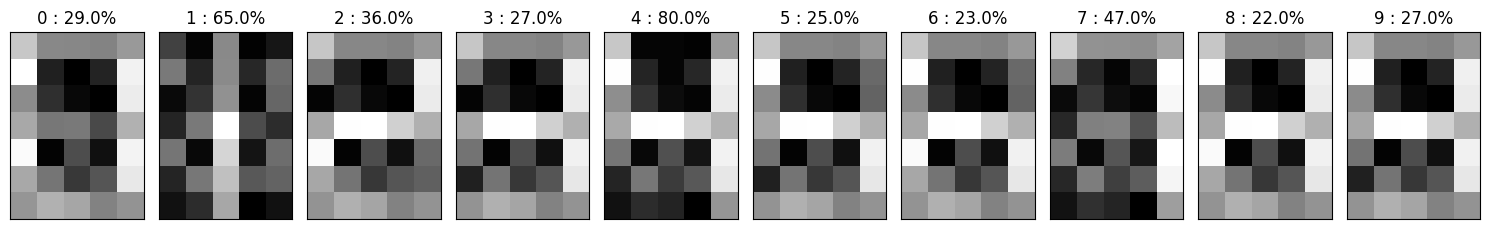

In [37]:
noise_size = 1.0
x_noised = data_mtrx + np.random.uniform(0, noise_size, img_size)

ypred = list([model.predict(xi) for xi in x_noised])

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(100)
fig.set_figwidth(15)
fig.set_figheight(5)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(x_noised[i].reshape(img_shape),  cmap='binary_r')
    j = np.argmax(ypred[i])

    ax.set_title(f"{j} : {(ypred[i][j] * 100).round()}%")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

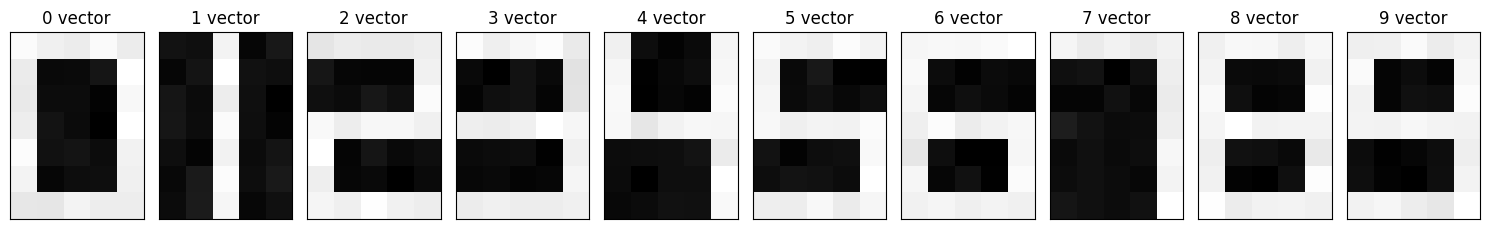

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=model.nOut)
fig.set_figwidth(15)
fig.set_figheight(5)
fig.set_dpi(100)

for i in range(model.nOut):
    img = axes[i].imshow(model.V[i].reshape(img_shape), cmap='binary_r')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title(f'{i} vector')

plt.tight_layout()
plt.show()